# **Weather Forecasting Project**

**Statistical Models for Data Science**

**Marco Colognesi - VR495478**


## **Loading, Converting and Cleaning of the Data**

In [33]:
# Importing libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats, signal
from scipy.fft import fft

import matplotlib.pyplot as plt
import seaborn as sns
import july
sns.set_theme()

The project starts with the **loading**, **converting** and **cleaning** of the data:
* Data is imported with the `pd.read_csv` method: the `['date']` column is **parsed** into a `'datetime64[ns]'` format thanks to the `parse_dates` option and is going to be used as a `DatetimeIndex`, the ideal type of index for a **time series analysis**.
* The **frequency** of the data is specified thanks to the `.asfreq()` method: in particular, our data shows a **calendar day frequency** (*daily*).

In [2]:
# Importing Training Data
train_data = pd.read_csv(
            filepath_or_buffer='raw_data\Weather ForecastingTrain.csv',
            # Parsing dates and using ['date'] as column
            parse_dates=['date'], index_col=['date']
            )

# Specifying the frequency as daily --> ('D') = calendar day frequency
train_data = train_data.asfreq('D')

# Showing a snippet of the data
display(train_data)

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-27,16.850000,67.550000,8.335000,1017.200000
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762


In [3]:
# Importing Testing Data
test_data = pd.read_csv(
            filepath_or_buffer='raw_data\Weather ForecastingTest.csv',
            # Parsing dates and using ['date'] as column
            parse_dates=['date'], index_col=['date']
            )

# Specifying the frequency as daily --> ('D') = calendar day frequency
test_data = test_data.asfreq('D')

# Showing a snippet of the data
display(test_data)

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...
2017-03-27,29.500000,38.625000,13.650000,1009.500000
2017-03-28,29.888889,40.666667,8.844444,1009.000000
2017-03-29,31.000000,34.500000,13.200000,1007.125000


Our **training dataset** provides **daily data** from the *1st of January 2013* to the *31st of December 2016*: a total of `1461` **observations**.

There are **4 parameters** (*columns*) describing weather, that are: `meantemp` (*which will be used as dependent variable for the forecast*), `humidity`, `wind_speed`, and `meanpressure`.

Instead, the **testing dataset** provides **daily data** from the ***first three-month period of 2017***: from 1st of January 2017 to the 31st of March 2017, a total of `90` **observations**.


In [4]:
# Data information
print('=== Train Data Information ===')
print(train_data.info())

=== Train Data Information ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2013-01-01 to 2016-12-31
Freq: D
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1461 non-null   float64
 1   humidity      1461 non-null   float64
 2   wind_speed    1461 non-null   float64
 3   meanpressure  1461 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB
None


In [5]:
print('=== Test Data Information ===')
print(test_data.info())

=== Test Data Information ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2017-01-01 to 2017-03-31
Freq: D
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      90 non-null     float64
 1   humidity      90 non-null     float64
 2   wind_speed    90 non-null     float64
 3   meanpressure  90 non-null     float64
dtypes: float64(4)
memory usage: 3.5 KB
None


To perform the **data cleaning** part, the presence of **null values** needs to be assessed: this can be done thanks to the `.isnull()` method.

In [6]:
# Checking if there are nulle values in the training data (NaN)
print('Null values in the training dataset:\n', train_data.isnull().sum())

print('\nNull values in the testing dataset:\n', train_data.isnull().sum())

Null values in the training dataset:
 meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Null values in the testing dataset:
 meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


There are **no null values** in our training data, thus no data cleaning operations is required at the moment.

For visualization purposes and further analysis a merged dataset with both training and testing information is created

In [4]:
# Concatenating training and testing
merged_df = pd.concat([train_data, test_data])

For data visualization purposes two new columns are added:

* `'Month`: indicating the **monthly period** (*year and month*)
* `'Year`: indicating the **year period**

In [5]:
# Adding 'Month' column (DatetimeIndex -> Period)
merged_df['Month'] = merged_df.index.to_period('M')
# Adding 'Year' column (DatetimeIndex -> Period)
merged_df['Year'] = merged_df.index.to_period('Y')

# Showing snippet of the data
display(merged_df)

,meantemp,humidity,wind_speed,meanpressure,Month,Year
date,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013-01,2013
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013-01,2013
2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013-01,2013
2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013-01,2013
2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013-01,2013
...,...,...,...,...,...,...
2017-03-27,29.500000,38.625000,13.650000,1009.500000,2017-03,2017
2017-03-28,29.888889,40.666667,8.844444,1009.000000,2017-03,2017
2017-03-29,31.000000,34.500000,13.200000,1007.125000,2017-03,2017


In [6]:
# Creating separate dataframes for each year
#2013
df_2013 = merged_df.loc[merged_df.index.year == 2013]
#2014
df_2014 = merged_df.loc[merged_df.index.year == 2014]
#2015
df_2015 = merged_df.loc[merged_df.index.year == 2015]
#2016
df_2016 = merged_df.loc[merged_df.index.year == 2016]

## **Exploring the dataset**

The `.describe()` method is used to represent the basic **central tendency measures**: `mean`, `standard deviation`, `min`, `max`, `percentiles` (*25%, 50%, 75%*).

In [10]:
display(merged_df.describe().T) 

,count,mean,std,min,25%,50%,75%,max
meantemp,1551.0,25.146134,7.355698,6.000000,18.500000,27.000000,31.125000,38.714286
humidity,1551.0,60.884516,16.646238,13.428571,50.375000,62.777778,72.330357,98.000000
wind_speed,1551.0,6.869216,4.502913,0.000000,3.608551,6.276923,9.262500,42.220000
meanpressure,1551.0,1010.682974,176.648249,-3.041667,1001.875000,1009.214286,1015.285714,7679.333333


* `"meantemp"` variable ranges from a **minimum** of `6°` to a **maximum** of `38.7°`, resulting in an **average** of `25.15°` degrees and a **standard deviation** of `7.36°`. It represents the *average daily temperature* and appears to be measured in *celsius*. This variable shows no particular values and seems already suitable

* `"humidity"`variable ranges from a **minimum** of `13.43` to a **maximum** of `98`, resulting in an **average** of `60.88` degrees and a **standard deviation** of `16.65`. It represents the *average daily relative humidity percentage*. The average value seems ok, however, the minimum value seems strange so the performance of an **outlier analysis** is required. For more information about the subject check: https://en.wikipedia.org/wiki/Humidity#Relative_humidity

* `"wind_speed"`variable ranges from a **minimum** of `0` to a **maximum** of `42.2`, resulting in an **average** of `6.87` and a **standard deviation** of `4.50`. It represents the *average daily wind speed* and is expressed in kilometres per hour (*according to the data source*). The average value seems ok (*might be a little high*), however, the maximum value seems strange so the performance of an **outlier analysis** is required. For more information about the subject check: https://en.wikipedia.org/wiki/Wind_speed

* `"meanpressure"`variable ranges from a **minimum** of `-3.04` to a **maximum** of `7679.33`, resulting in an **average** of `1010.68` and a **standard deviation** of `176.65`. It represents the *average daily atmospheric pressure* and is usually expressed in units of hectopascals (hPa) or millibars (mb). The average value seems ok, however, both the minimum and maximum values seem to be completely wrong so the performance of an **outlier analysis** is required. For more information about the subject check: https://en.wikipedia.org/wiki/Atmospheric_pressure

### **Outlier Detection**

The **IQR outlier detection** method will be used, according to which observations that fall below $\;Q1-1.5\,IQR\;$ or above $\;Q3+1.5\,IQR\;$ are considered **outliers**

* $Q1$ represents the 25th percentile of the data
* $Q3$ represents the 75th percentile of the data
* $IQR$ is the **Interquantile Range** and is computed as $Q3-Q1$

#### `"meantemp"`

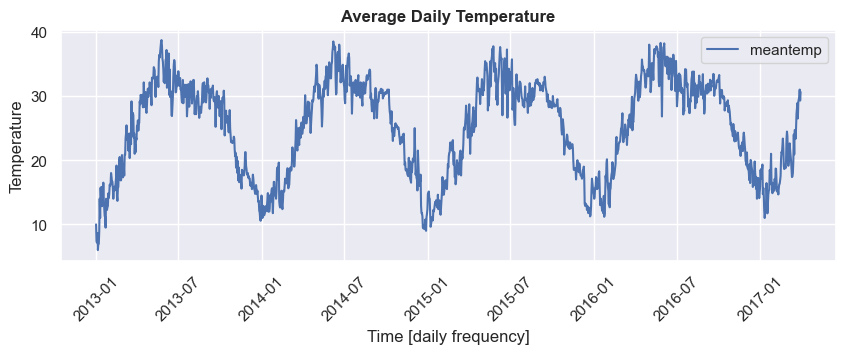

In [8]:
# "meantemp" trend plot
plt.figure(figsize=(10,3))
plt.plot(merged_df['meantemp'], label='meantemp')
plt.title('Average Daily Temperature', weight='bold')
plt.xlabel('Time [daily frequency]')
plt.tick_params(axis='x', rotation=45)
plt.ylabel('Temperature')
plt.legend()
plt.show()

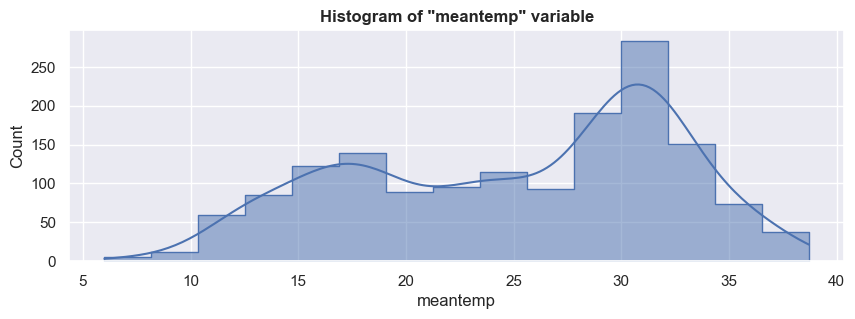

In [9]:
plt.figure(figsize=(10,3))
plt.title('Histogram of "meantemp" variable', weight='bold')
sns.histplot(data=merged_df, x='meantemp', kde=True, element='step')
plt.show()

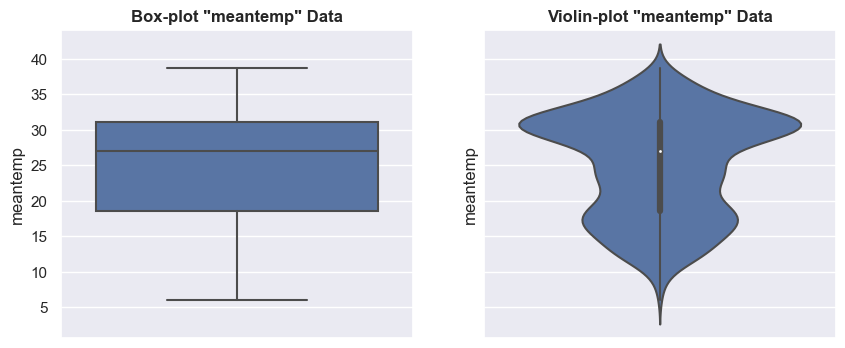

In [10]:
# Box plot / Violin plot - Overall Comparison
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharey=True)
# Box-plot
sns.boxplot(y = merged_df['meantemp'], ax=ax[0]).set_title('Box-plot "meantemp" Data', weight='bold')
# Violin-plot
sns.violinplot(y = merged_df['meantemp'], ax=ax[1]).set_title('Violin-plot "meantemp" Data', weight='bold')
plt.show()

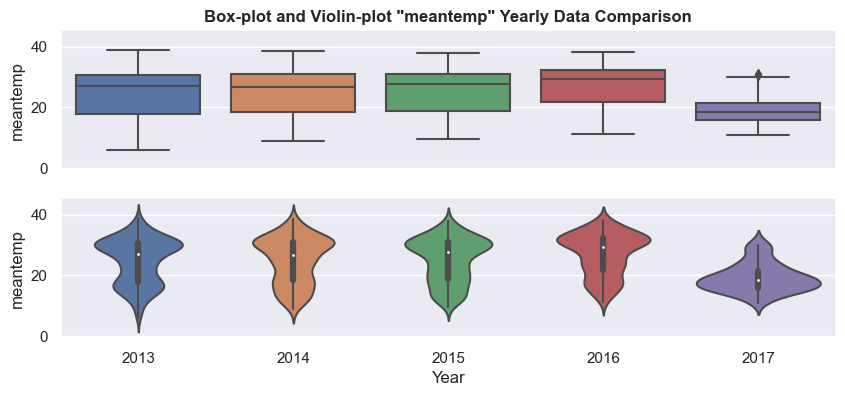

In [11]:
# Box plot / Violin plot - Yearly Comparison
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,4), sharex=True, sharey=True)
# Boxplot
sns.boxplot(data=merged_df, x='Year', y='meantemp', ax=ax[0]).set_title('Box-plot and Violin-plot "meantemp" Yearly Data Comparison', weight='bold')
# Violinplot
sns.violinplot(data=merged_df, x='Year', y='meantemp', ax=ax[1])
ax[0].set_xlabel('')
plt.show()

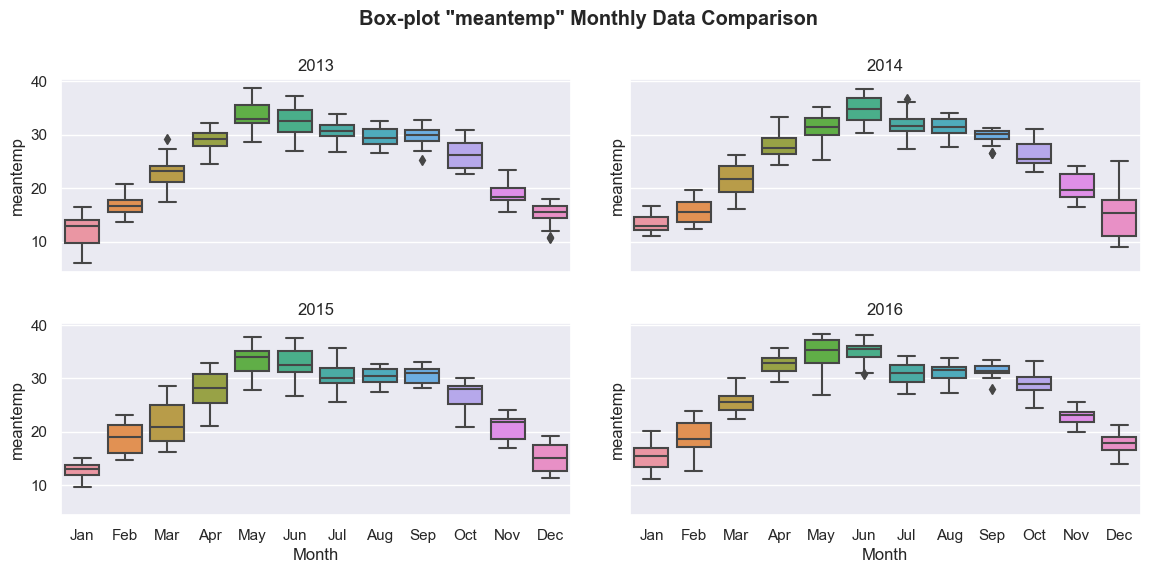

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,6), sharex=True, sharey=True)
fig.suptitle('Box-plot "meantemp" Monthly Data Comparison', weight='bold', y=0.95)
fig.tight_layout(pad=2.25)
sns.boxplot(x= df_2013['Month'].dt.strftime('%b'), y= df_2013['meantemp'], ax=axes[0,0]).set_title('2013')
axes[0,0].set_xlabel('')
sns.boxplot(x= df_2014['Month'].dt.strftime('%b'), y= df_2014['meantemp'], ax=axes[0,1]).set_title('2014')
axes[0,1].set_xlabel('')
sns.boxplot(x= df_2015['Month'].dt.strftime('%b'), y= df_2015['meantemp'], ax=axes[1,0]).set_title('2015')
sns.boxplot(x= df_2016['Month'].dt.strftime('%b'), y= df_2016['meantemp'], ax=axes[1,1]).set_title('2016')
plt.show()

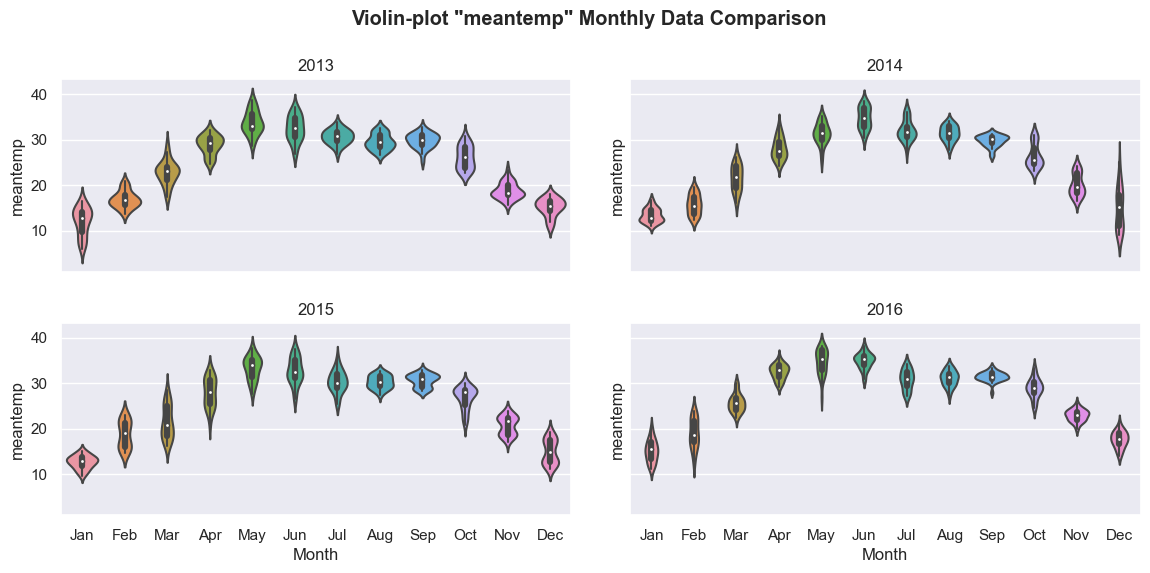

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,6), sharex=True, sharey=True)
fig.suptitle('Violin-plot "meantemp" Monthly Data Comparison', weight='bold', y=0.95)
fig.tight_layout(pad=2.25)
sns.violinplot(x= df_2013['Month'].dt.strftime('%b'), y= df_2013['meantemp'], ax=axes[0,0]).set_title('2013')
axes[0,0].set_xlabel('')
sns.violinplot(x= df_2014['Month'].dt.strftime('%b'), y= df_2014['meantemp'], ax=axes[0,1]).set_title('2014')
axes[0,1].set_xlabel('')
sns.violinplot(x= df_2015['Month'].dt.strftime('%b'), y= df_2015['meantemp'], ax=axes[1,0]).set_title('2015')
sns.violinplot(x= df_2016['Month'].dt.strftime('%b'), y= df_2016['meantemp'], ax=axes[1,1]).set_title('2016')
plt.show()

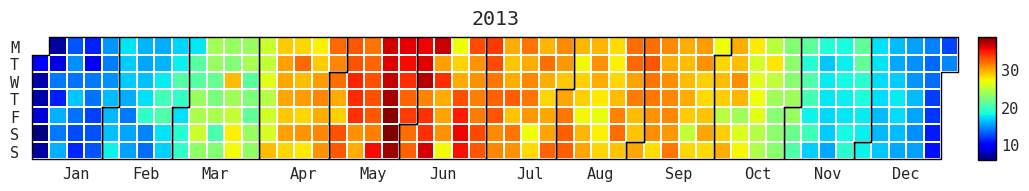

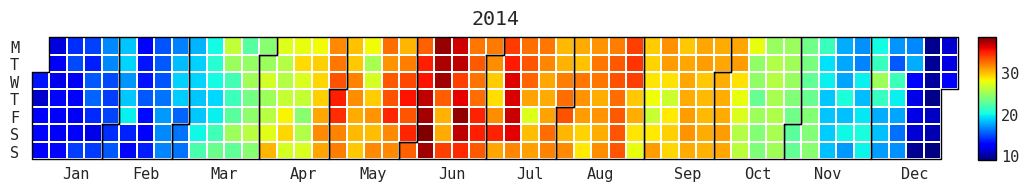

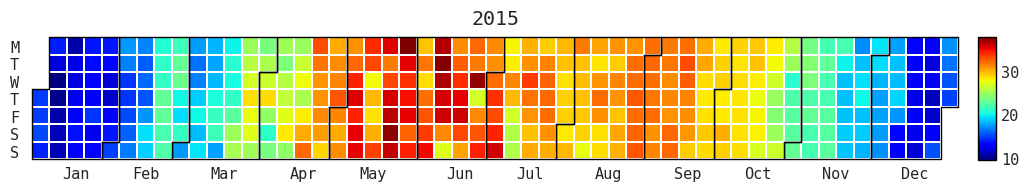

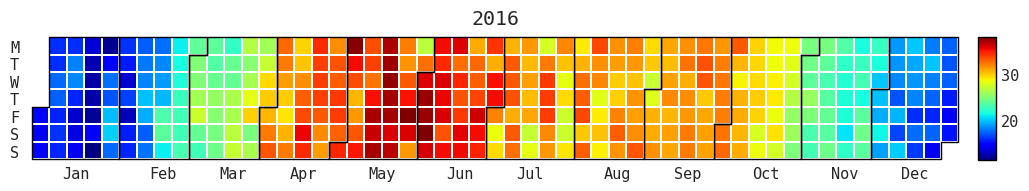

In [20]:
# Calendar plots for each year
july.heatmap(df_2013.index, df_2013['meantemp'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2014.index, df_2014['meantemp'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2015.index, df_2015['meantemp'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2016.index, df_2016['meantemp'].values, cmap='jet', month_grid=True, colorbar=True)
plt.show()

In [18]:
# Finding Q1 (25% percentile) and Q3 (75% percentile)
Q1_meantemp = np.quantile(merged_df['meantemp'], 0.25)
Q3_meantemp = np.quantile(merged_df['meantemp'], 0.75)

print(f"Q1 for 'meantemp' variable is: {Q1_meantemp}")
print(f"Q3 for 'meantemp' variable is: {Q3_meantemp}")
print("=================================")

# Finding IQR (Q3-Q1)
IQR_meantemp = Q3_meantemp - Q1_meantemp

print(f"IQR for 'meantemp' variable is: {IQR_meantemp}")
print("=================================")

# Finding limits (minimum and maximum)
lower_limit_meantemp = Q1_meantemp - 1.5*IQR_meantemp
upper_limit_meantemp = Q3_meantemp + 1.5*IQR_meantemp

print(f"Lower limit for outlier detection is: {lower_limit_meantemp}")
print(f"Upper limit for outlier detection is: {upper_limit_meantemp}")
print("=================================")

# Finding outliers (if a value is < than lower limit or > than upper limit)
outliers_meantemp = [x for x in merged_df['meantemp'] if x < lower_limit_meantemp or x > upper_limit_meantemp]

print(f"{len(outliers_meantemp)} outliers were found:")
print(outliers_meantemp)

Q1 for 'meantemp' variable is: 18.5
Q3 for 'meantemp' variable is: 31.125
IQR for 'meantemp' variable is: 12.625
Lower limit for outlier detection is: -0.4375
Upper limit for outlier detection is: 50.0625
0 outliers were found:
[]


The **graphs** and basic **central tendency measures** represented above show that `"meantemp"` variable has **no apparent outlier** data.

The IQR outlier detection method reiterated this conclusion.

#### `"humidity"`

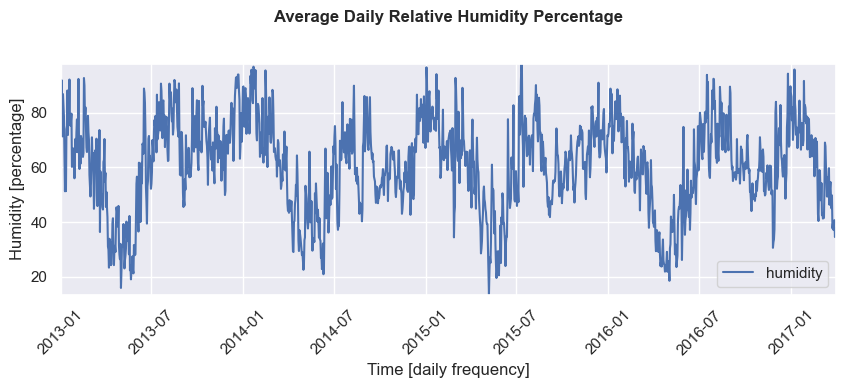

In [25]:
# "humidity" plot
plt.figure(figsize=(10,3))
plt.plot(merged_df['humidity'], label='humidity')
plt.title('Average Daily Relative Humidity Percentage', weight='bold')
plt.xlabel('Time [daily frequency]')
plt.tick_params(axis='x', rotation=45)
plt.ylabel('Humidity [percentage]')
plt.legend(loc='lower right')
plt.show()

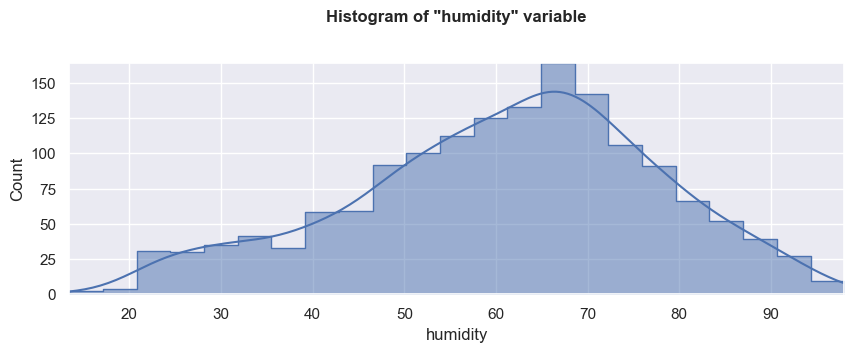

In [27]:
plt.figure(figsize=(10,3))
plt.title('Histogram of "humidity" variable', weight='bold')
sns.histplot(data=merged_df, x='humidity', kde=True, element='step')
plt.show()

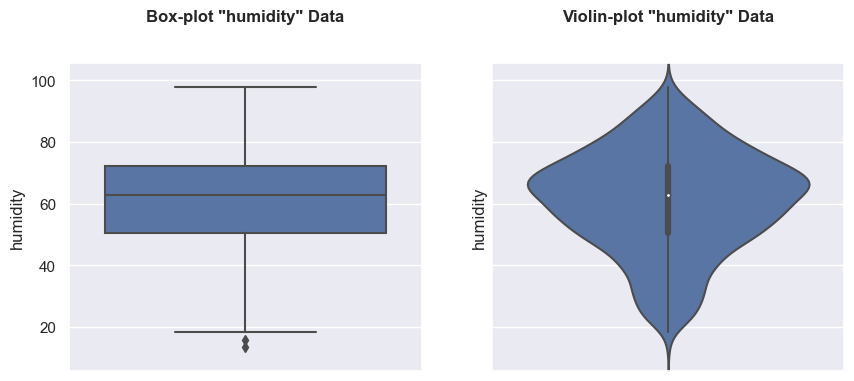

In [28]:
# Box plot / Violin plot - Overall Comparison
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharey=True)
# Box-plot
sns.boxplot(y = merged_df['humidity'], ax=ax[0]).set_title('Box-plot "humidity" Data', weight='bold')
# Violin-plot
sns.violinplot(y = merged_df['humidity'], ax=ax[1]).set_title('Violin-plot "humidity" Data', weight='bold')
plt.show()

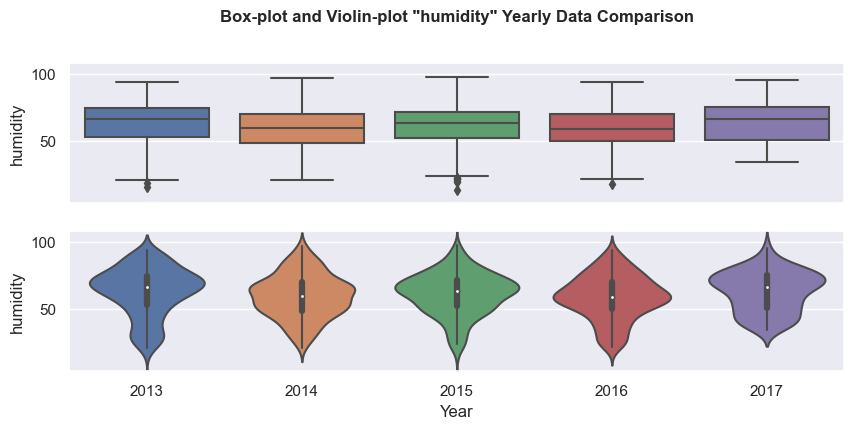

In [29]:
# Box plot / Violin plot - Yearly Comparison
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,4), sharex=True, sharey=True)
# Boxplot
sns.boxplot(data=merged_df, x='Year', y='humidity', ax=ax[0]).set_title('Box-plot and Violin-plot "humidity" Yearly Data Comparison', weight='bold')
# Violinplot
sns.violinplot(data=merged_df, x='Year', y='humidity', ax=ax[1])
ax[0].set_xlabel('')
plt.show()

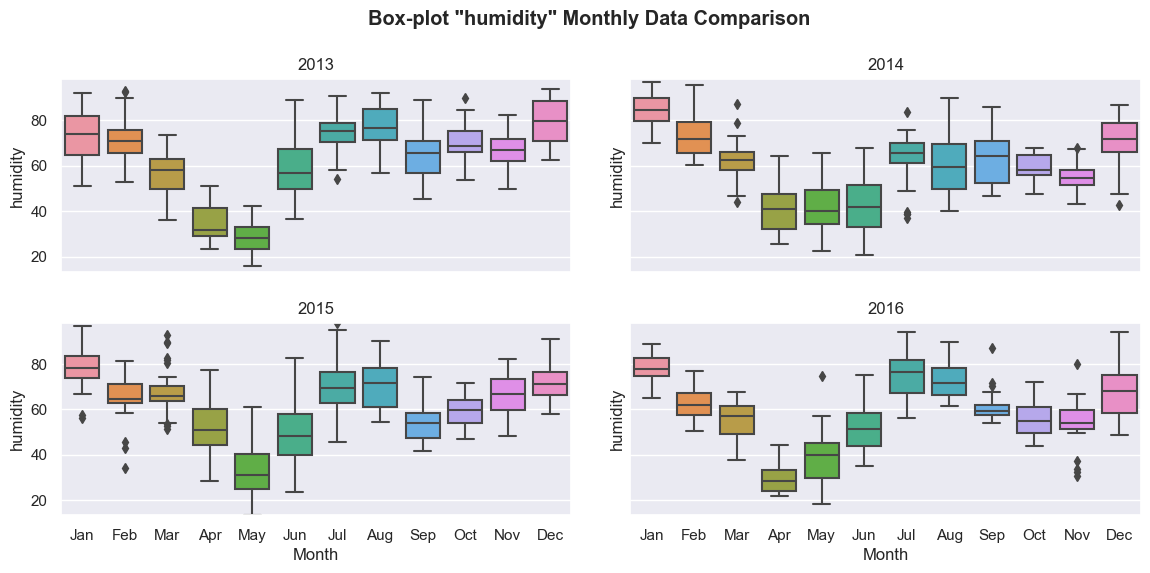

In [35]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,6), sharex=True, sharey=True)
fig.suptitle('Box-plot "humidity" Monthly Data Comparison', weight='bold', y=0.95)
fig.tight_layout(pad=2.25)
sns.boxplot(x= df_2013['Month'].dt.strftime('%b'), y= df_2013['humidity'], ax=axes[0,0]).set_title('2013', y=0.83)
axes[0,0].set_xlabel('')
sns.boxplot(x= df_2014['Month'].dt.strftime('%b'), y= df_2014['humidity'], ax=axes[0,1]).set_title('2014', y=0.83)
axes[0,1].set_xlabel('')
sns.boxplot(x= df_2015['Month'].dt.strftime('%b'), y= df_2015['humidity'], ax=axes[1,0]).set_title('2015', y=0.83)
sns.boxplot(x= df_2016['Month'].dt.strftime('%b'), y= df_2016['humidity'], ax=axes[1,1]).set_title('2016', y=0.83)
plt.show()

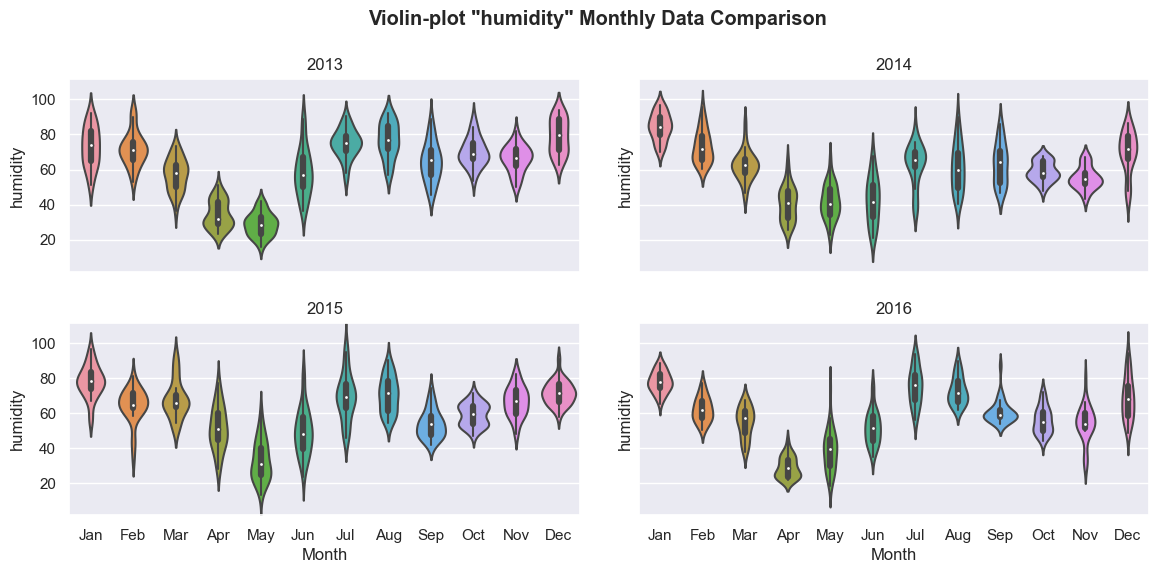

In [36]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,6), sharex=True, sharey=True)
fig.suptitle('Violin-plot "humidity" Monthly Data Comparison', weight='bold', y=0.95)
fig.tight_layout(pad=2.25)
sns.violinplot(x= df_2013['Month'].dt.strftime('%b'), y= df_2013['humidity'], ax=axes[0,0]).set_title('2013', y=0.83)
axes[0,0].set_xlabel('')
sns.violinplot(x= df_2014['Month'].dt.strftime('%b'), y= df_2014['humidity'], ax=axes[0,1]).set_title('2014', y=0.83)
axes[0,1].set_xlabel('')
sns.violinplot(x= df_2015['Month'].dt.strftime('%b'), y= df_2015['humidity'], ax=axes[1,0]).set_title('2015', y=0.83)
sns.violinplot(x= df_2016['Month'].dt.strftime('%b'), y= df_2016['humidity'], ax=axes[1,1]).set_title('2016', y=0.83)
plt.show()

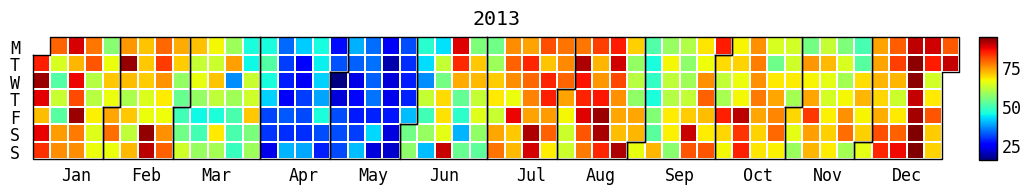

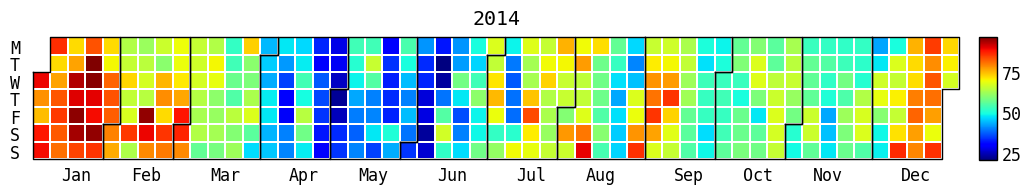

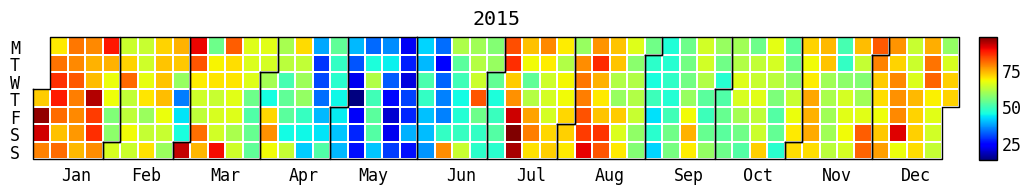

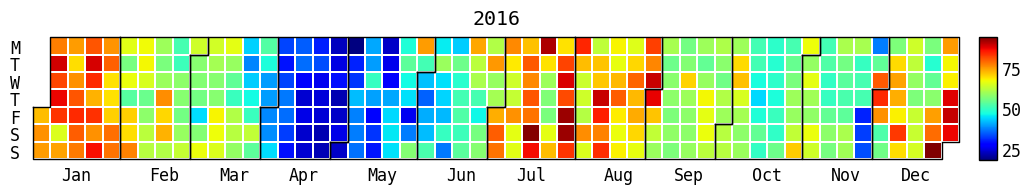

In [25]:
# Calendar plots for each year
july.heatmap(df_2013.index, df_2013['humidity'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2014.index, df_2014['humidity'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2015.index, df_2015['humidity'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2016.index, df_2016['humidity'].values, cmap='jet', month_grid=True, colorbar=True)
plt.show()

In [26]:
# Finding Q1 (25% percentile) and Q3 (75% percentile)
Q1_humidity = np.quantile(merged_df['humidity'], 0.25)
Q3_humidity = np.quantile(merged_df['humidity'], 0.75)

print(f"Q1 for 'humidity' variable is: {Q1_humidity}")
print(f"Q3 for 'humidity' variable is: {Q3_humidity}")
print("=================================")

# Finding IQR (Q3-Q1)
IQR_humidity = Q3_humidity - Q1_humidity

print(f"IQR for 'humidity' variable is: {IQR_humidity}")
print("=================================")

# Finding limits (minimum and maximum)
lower_limit_humidity = Q1_humidity - 1.5*IQR_humidity
upper_limit_humidity = Q3_humidity + 1.5*IQR_humidity

print(f"Lower limit for outlier detection is: {lower_limit_humidity}")
print(f"Upper limit for outlier detection is: {upper_limit_humidity}")
print("=================================")

# Finding outliers (if a value is < than lower limit or > than upper limit)
outliers_humidity = [x for x in merged_df['humidity'] if x < lower_limit_humidity or x > upper_limit_humidity]

print(f"{len(outliers_humidity)} outliers were found:")
print(outliers_humidity)

display(merged_df.loc[merged_df['humidity'].isin(outliers_humidity)])

Q1 for 'humidity' variable is: 50.375
Q3 for 'humidity' variable is: 72.33035714285714
IQR for 'humidity' variable is: 21.95535714285714
Lower limit for outlier detection is: 17.441964285714292
Upper limit for outlier detection is: 105.26339285714285
2 outliers were found:
[15.857142857142858, 13.428571428571429]


,meantemp,humidity,wind_speed,meanpressure,Month,Year
date,,,,,,
2013-05-01,31.857143,15.857143,12.685714,1002.833333,2013-05,2013
2015-05-07,35.428571,13.428571,15.342857,1003.571429,2015-05,2015


`"humidity"` variable shows a **noisier pattern** than the mean temperature.

The **plots** and the basic **central tendency measures** represented before show that **no particular anomalies** were found. 

Through the **IQR outlier detection** method only two values were identified as outliers: 
* They are not extremely far from the lower limit and we can't determine with certainty if they are due to measurement errors or due to severe weather conditions;
* Replacing them would not bring significant improvement to the variable, so they will be left as they are (*rare events*).

#### `"wind_speed"`

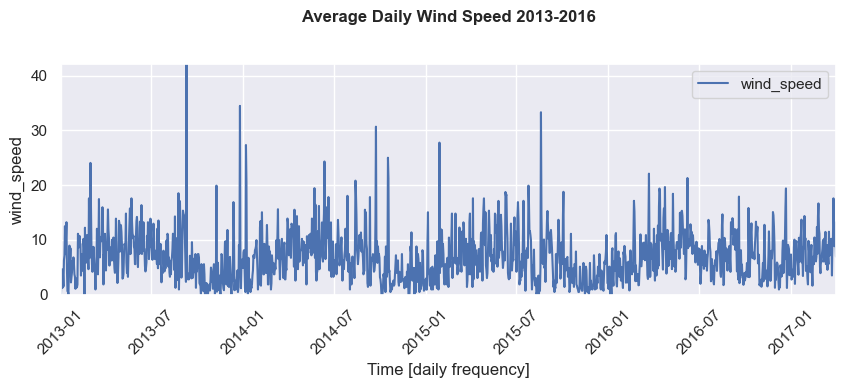

In [38]:
# "wind_speed" plot
plt.figure(figsize=(10,3))
plt.plot(merged_df['wind_speed'], label='wind_speed')
plt.title('Average Daily Wind Speed 2013-2016', weight='bold')
plt.xlabel('Time [daily frequency]')
plt.tick_params(axis='x', rotation=45)
plt.ylabel('wind_speed')
plt.legend()
plt.show()

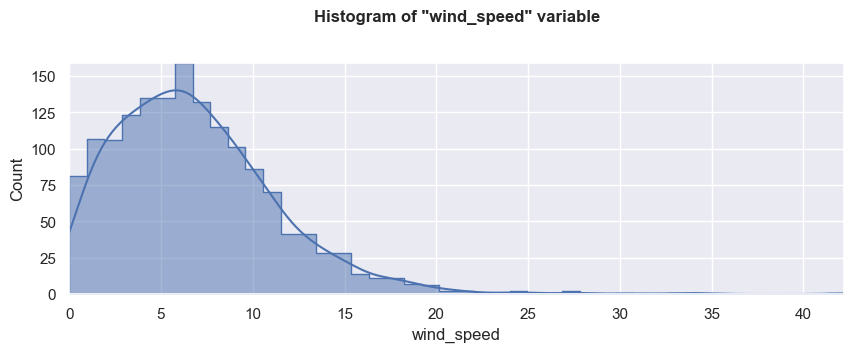

In [39]:
plt.figure(figsize=(10,3))
plt.title('Histogram of "wind_speed" variable', weight='bold')
sns.histplot(data=merged_df, x='wind_speed', kde=True, element='step')
plt.show()

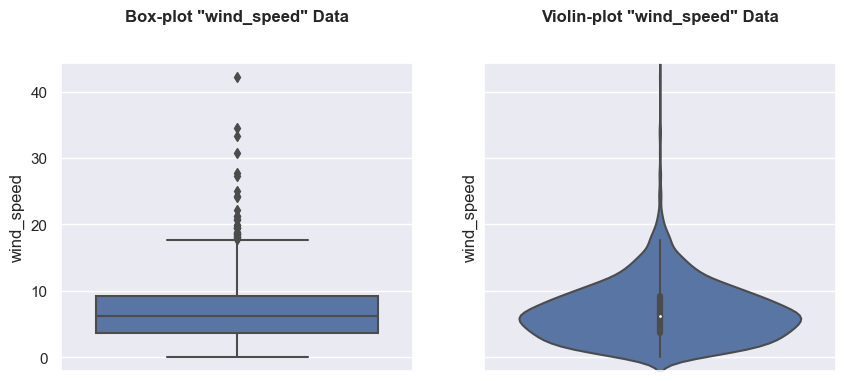

In [40]:
# Box plot / Violin plot - Overall Comparison
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharey=True)
# Box-plot
sns.boxplot(y = merged_df['wind_speed'], ax=ax[0]).set_title('Box-plot "wind_speed" Data', weight='bold')
# Violin-plot
sns.violinplot(y = merged_df['wind_speed'], ax=ax[1]).set_title('Violin-plot "wind_speed" Data', weight='bold')
plt.show()

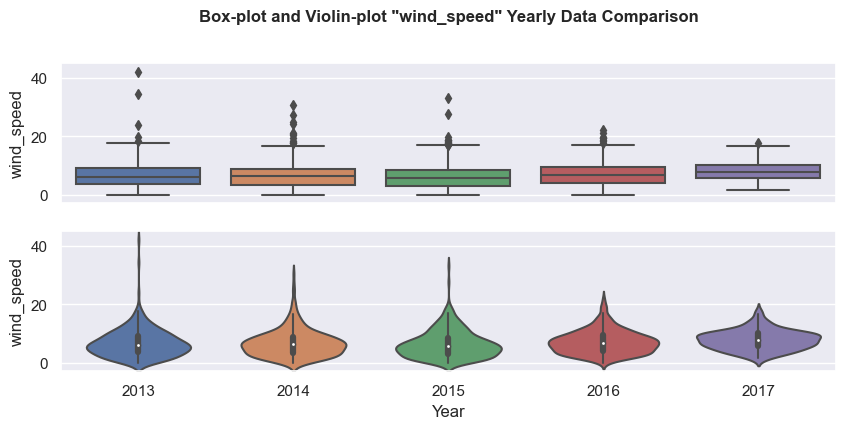

In [41]:
# Box plot / Violin plot - Yearly Comparison
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,4), sharex=True, sharey=True)
# Boxplot
sns.boxplot(data=merged_df, x='Year', y='wind_speed', ax=ax[0]).set_title('Box-plot and Violin-plot "wind_speed" Yearly Data Comparison', weight='bold')
# Violinplot
sns.violinplot(data=merged_df, x='Year', y='wind_speed', ax=ax[1])
ax[0].set_xlabel('')
plt.show()

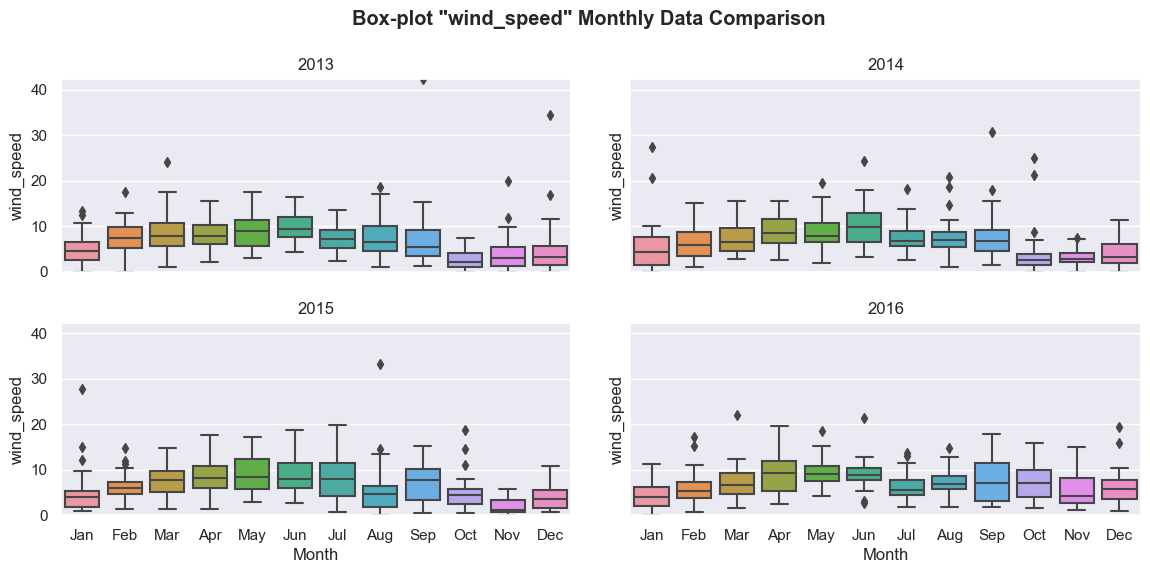

In [42]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,6), sharex=True, sharey=True)
fig.suptitle('Box-plot "wind_speed" Monthly Data Comparison', weight='bold', y=0.95)
fig.tight_layout(pad=2.25)
sns.boxplot(x= df_2013['Month'].dt.strftime('%b'), y= df_2013['wind_speed'], ax=axes[0,0]).set_title('2013', y=0.83)
axes[0,0].set_xlabel('')
sns.boxplot(x= df_2014['Month'].dt.strftime('%b'), y= df_2014['wind_speed'], ax=axes[0,1]).set_title('2014', y=0.83)
axes[0,1].set_xlabel('')
sns.boxplot(x= df_2015['Month'].dt.strftime('%b'), y= df_2015['wind_speed'], ax=axes[1,0]).set_title('2015', y=0.83)
sns.boxplot(x= df_2016['Month'].dt.strftime('%b'), y= df_2016['wind_speed'], ax=axes[1,1]).set_title('2016', y=0.83)
plt.show()

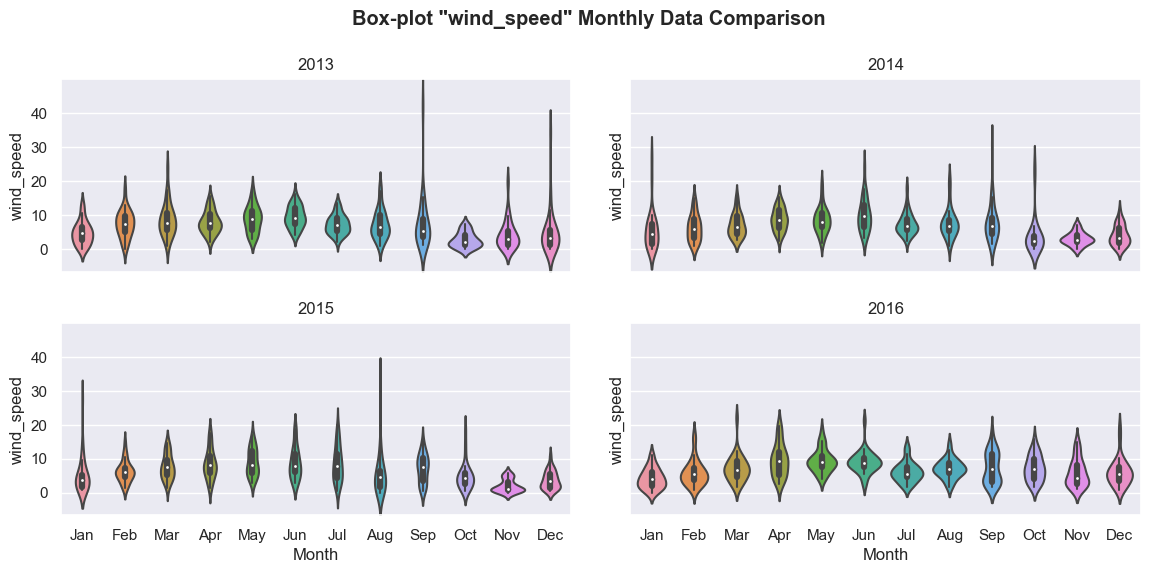

In [43]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,6), sharex=True, sharey=True)
fig.suptitle('Box-plot "wind_speed" Monthly Data Comparison', weight='bold', y=0.95)
fig.tight_layout(pad=2.25)
sns.violinplot(x= df_2013['Month'].dt.strftime('%b'), y= df_2013['wind_speed'], ax=axes[0,0]).set_title('2013', y=0.83)
axes[0,0].set_xlabel('')
sns.violinplot(x= df_2014['Month'].dt.strftime('%b'), y= df_2014['wind_speed'], ax=axes[0,1]).set_title('2014', y=0.83)
axes[0,1].set_xlabel('')
sns.violinplot(x= df_2015['Month'].dt.strftime('%b'), y= df_2015['wind_speed'], ax=axes[1,0]).set_title('2015', y=0.83)
sns.violinplot(x= df_2016['Month'].dt.strftime('%b'), y= df_2016['wind_speed'], ax=axes[1,1]).set_title('2016', y=0.83)
plt.show()

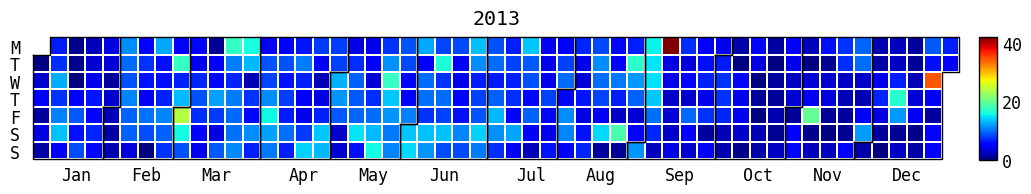

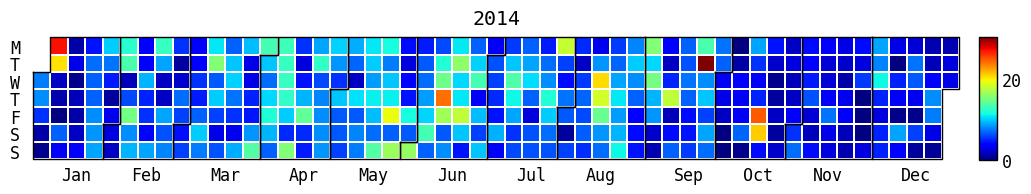

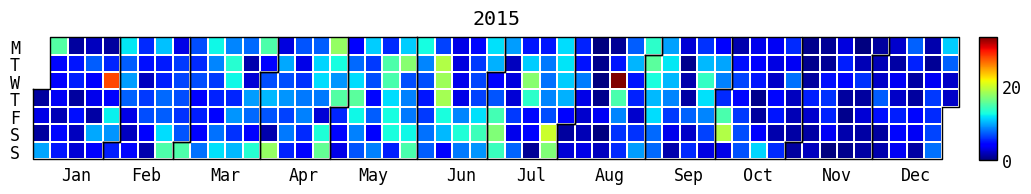

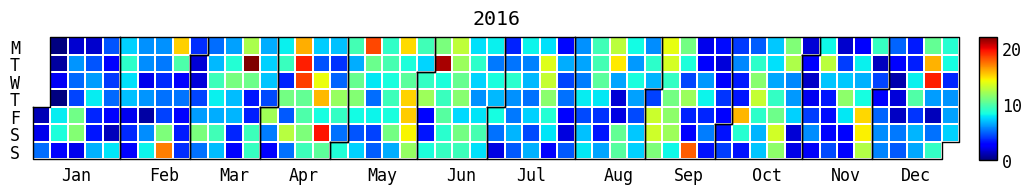

In [33]:
# Calendar plots for each year
july.heatmap(df_2013.index, df_2013['wind_speed'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2014.index, df_2014['wind_speed'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2015.index, df_2015['wind_speed'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2016.index, df_2016['wind_speed'].values, cmap='jet', month_grid=True, colorbar=True)
plt.show()

In [44]:
# Finding Q1 (25% percentile) and Q3 (75% percentile)
Q1_windspeed = np.quantile(merged_df['wind_speed'], 0.25)
Q3_windspeed = np.quantile(merged_df['wind_speed'], 0.75)

print(f"Q1 for 'wind_speed' variable is: {Q1_windspeed}")
print(f"Q3 for 'wind_speed' variable is: {Q3_windspeed}")
print("=================================")

# Finding IQR (Q3-Q1)
IQR_windspeed = Q3_windspeed - Q1_windspeed

print(f"IQR for 'wind_speed' variable is: {IQR_windspeed}")
print("=================================")

# Finding limits (minimum and maximum)
lower_limit_windspeed = Q1_windspeed - 1.5*IQR_windspeed
upper_limit_windspeed = Q3_windspeed + 1.5*IQR_windspeed

print(f"Lower limit for outlier detection is: {lower_limit_windspeed}")
print(f"Upper limit for outlier detection is: {upper_limit_windspeed}")
print("=================================")

# Finding outliers (if a value is < than lower limit or > than upper limit)
outliers_windspeed = [x for x in merged_df['wind_speed'] if x < lower_limit_windspeed or x > upper_limit_windspeed]

print(f"{len(outliers_windspeed)} outliers were found:")
print(outliers_windspeed)

display(merged_df.loc[merged_df['wind_speed'].isin(outliers_windspeed)])

Q1 for 'wind_speed' variable is: 3.6085507246376816
Q3 for 'wind_speed' variable is: 9.2625
IQR for 'wind_speed' variable is: 5.653949275362318
Lower limit for outlier detection is: -4.872373188405795
Upper limit for outlier detection is: 17.743423913043475
32 outliers were found:
[24.066666666666663, 18.525, 42.22, 19.9125, 34.4875, 27.3375, 20.6, 19.450000000000003, 24.325, 17.825, 18.05, 20.825, 18.5125, 17.825, 30.685714285714283, 25.0125, 21.3, 27.775, 18.75, 18.05, 18.2875, 19.9125, 33.325, 18.785714285714285, 22.1, 19.380000000000003, 18.64375, 19.65384615384616, 18.425, 21.30625, 17.908333333333335, 19.40476190476191]


,meantemp,humidity,wind_speed,meanpressure,Month,Year
date,,,,,,
2013-03-01,17.333333,49.333333,24.066667,1016.333333,2013-03,2013
2013-08-24,32.000000,71.250000,18.525000,1000.333333,2013-08,2013
2013-09-09,31.000000,57.500000,42.220000,1007.000000,2013-09,2013
2013-11-08,18.000000,82.200000,19.912500,1015.625000,2013-11,2013
2013-12-25,13.666667,63.166667,34.487500,1020.625000,2013-12,2013
2014-01-06,11.428571,86.285714,27.337500,1017.625000,2014-01,2014
2014-01-07,12.142857,72.285714,20.600000,1017.750000,2014-01,2014
2014-05-23,34.625000,32.750000,19.450000,1000.000000,2014-05,2014
2014-06-12,32.875000,39.250000,24.325000,997.000000,2014-06,2014


The IQR outlier detection method identified several values as outliers. 

Outliers are not necessarily errors: they are just data points that differ significantly from other observations and can be due to rare events that happen within our measurements.

We do not know the exact context of this dataset so we cannot determine with certainty whether these outliers are actually attributable to errors or due to extreme weather events (*true outliers*). 

The maximum value within this variable is 42 kmh which, according to Beaufort Wind Scale, is considered a strong breeze, a weather condition that, while not typical, is not impossible to achieve. 
For more information: https://en.wikipedia.org/wiki/Beaufort_scale

Nevertheless, looking at the calendar plots, some values seem highly suspicious and thus are gonna be fixed.

In [45]:
# Replacing outliers using 'bfill' method
# First step --> Turn outliers into NaN
merged_df.loc[merged_df['wind_speed'].isin(outliers_windspeed), 'wind_speed'] = np.nan
# Second step --> Fill NaN
merged_df = merged_df.fillna(method='backfill')

# Update separate dataframes for each year
#2013
df_2013 = merged_df.loc[merged_df.index.year == 2013]
#2014
df_2014 = merged_df.loc[merged_df.index.year == 2014]
#2015
df_2015 = merged_df.loc[merged_df.index.year == 2015]
#2016
df_2016 = merged_df.loc[merged_df.index.year == 2016]

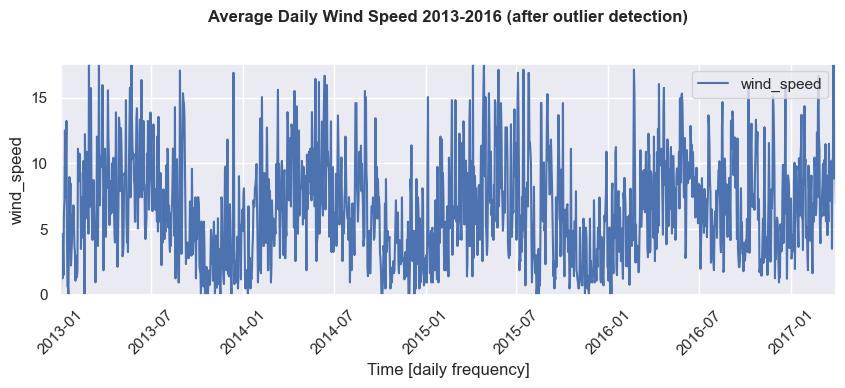

In [47]:
# "wind_speed" plot
plt.figure(figsize=(10,3))
plt.plot(merged_df['wind_speed'], label='wind_speed')
plt.title('Average Daily Wind Speed 2013-2016 (after outlier detection)', weight='bold')
plt.xlabel('Time [daily frequency]')
plt.tick_params(axis='x', rotation=45)
plt.ylabel('wind_speed')
plt.legend()
plt.show()

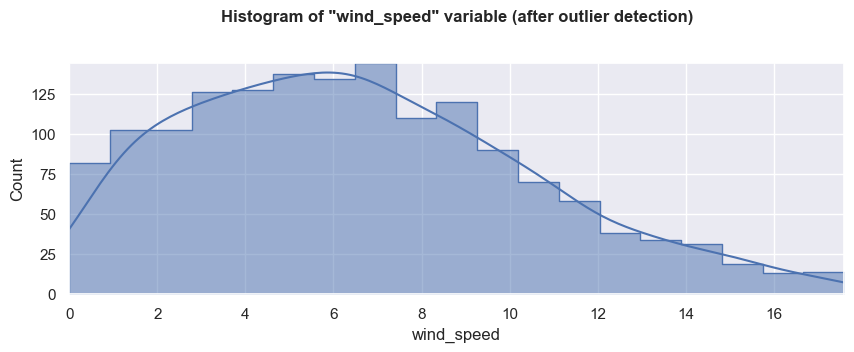

In [48]:
plt.figure(figsize=(10,3))
plt.title('Histogram of "wind_speed" variable (after outlier detection)', weight='bold')
sns.histplot(data=merged_df, x='wind_speed', kde=True, element='step')
plt.show()

In [38]:
display(merged_df['wind_speed'].describe())

count    1551.000000
mean        6.577856
std         3.895417
min         0.000000
25%         3.487500
50%         6.250000
75%         9.123538
max        17.600000
Name: wind_speed, dtype: float64

After the **outlier detection**, the **average daily wind speed** is now `6.58 kmh`, with a **standard deviation** of `3.9`. The **maximum** is now `17.6 kmh`.

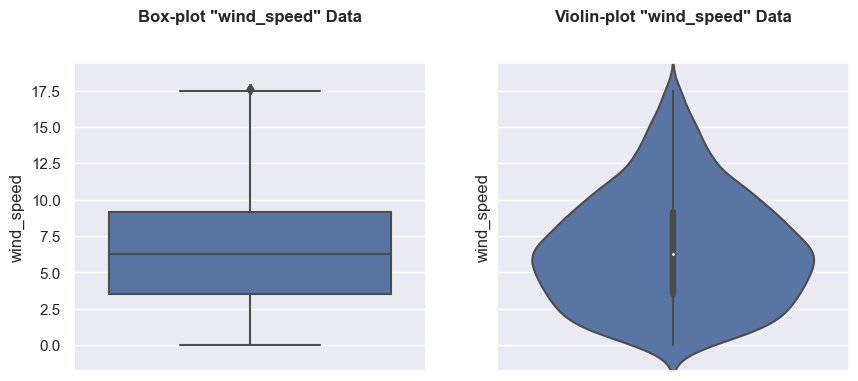

In [49]:
# Box plot / Violin plot - Overall Comparison
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharey=True)
# Box-plot
sns.boxplot(y = merged_df['wind_speed'], ax=ax[0]).set_title('Box-plot "wind_speed" Data', weight='bold')
# Violin-plot
sns.violinplot(y = merged_df['wind_speed'], ax=ax[1]).set_title('Violin-plot "wind_speed" Data', weight='bold')
plt.show()

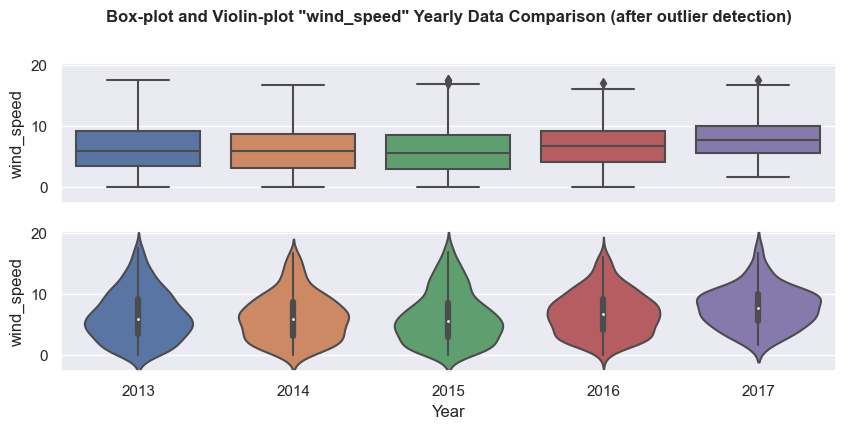

In [50]:
# Box plot / Violin plot - Yearly Comparison
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,4), sharex=True, sharey=True)
# Boxplot
sns.boxplot(data=merged_df, x='Year', y='wind_speed', ax=ax[0]).set_title('Box-plot and Violin-plot "wind_speed" Yearly Data Comparison (after outlier detection)', weight='bold')
# Violinplot
sns.violinplot(data=merged_df, x='Year', y='wind_speed', ax=ax[1])
ax[0].set_xlabel('')
plt.show()

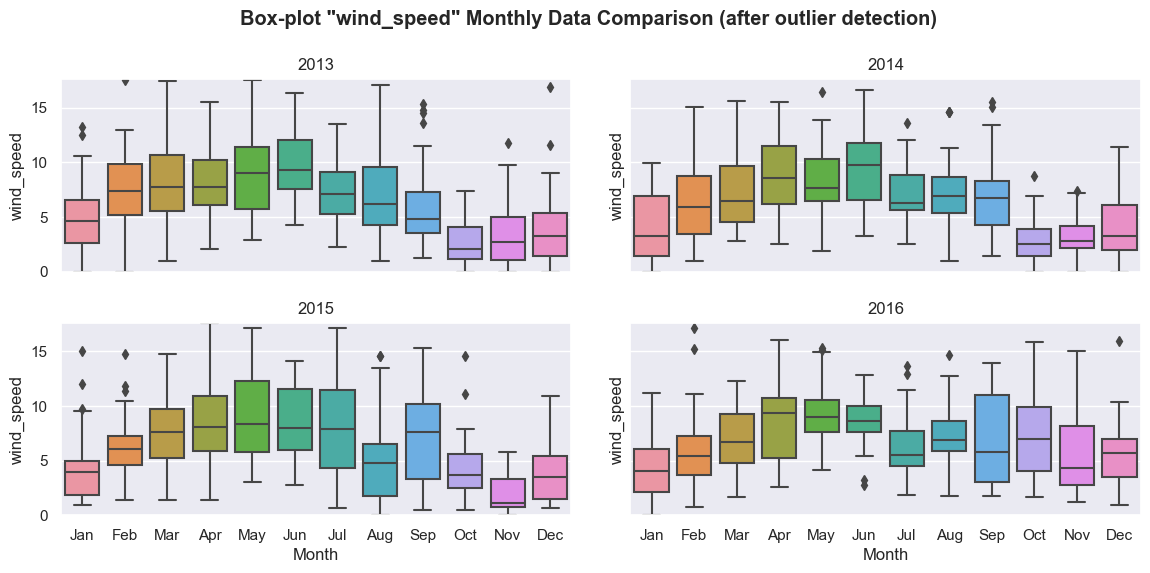

In [51]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,6), sharex=True, sharey=True)
fig.suptitle('Box-plot "wind_speed" Monthly Data Comparison (after outlier detection)', weight='bold', y=0.95)
fig.tight_layout(pad=2.25)
sns.boxplot(x= df_2013['Month'].dt.strftime('%b'), y= df_2013['wind_speed'], ax=axes[0,0]).set_title('2013', y=0.83)
axes[0,0].set_xlabel('')
sns.boxplot(x= df_2014['Month'].dt.strftime('%b'), y= df_2014['wind_speed'], ax=axes[0,1]).set_title('2014', y=0.83)
axes[0,1].set_xlabel('')
sns.boxplot(x= df_2015['Month'].dt.strftime('%b'), y= df_2015['wind_speed'], ax=axes[1,0]).set_title('2015', y=0.83)
sns.boxplot(x= df_2016['Month'].dt.strftime('%b'), y= df_2016['wind_speed'], ax=axes[1,1]).set_title('2016', y=0.83)
plt.show()

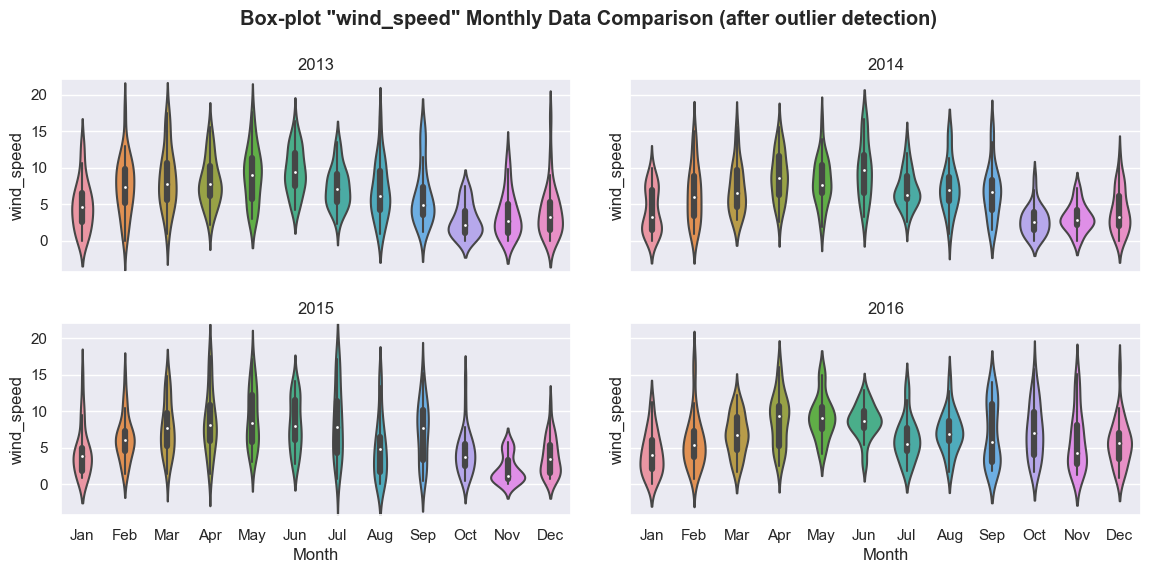

In [52]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,6), sharex=True, sharey=True)
fig.suptitle('Box-plot "wind_speed" Monthly Data Comparison (after outlier detection)', weight='bold', y=0.95)
fig.tight_layout(pad=2.25)
sns.violinplot(x= df_2013['Month'].dt.strftime('%b'), y= df_2013['wind_speed'], ax=axes[0,0]).set_title('2013', y=0.83)
axes[0,0].set_xlabel('')
sns.violinplot(x= df_2014['Month'].dt.strftime('%b'), y= df_2014['wind_speed'], ax=axes[0,1]).set_title('2014', y=0.83)
axes[0,1].set_xlabel('')
sns.violinplot(x= df_2015['Month'].dt.strftime('%b'), y= df_2015['wind_speed'], ax=axes[1,0]).set_title('2015', y=0.83)
sns.violinplot(x= df_2016['Month'].dt.strftime('%b'), y= df_2016['wind_speed'], ax=axes[1,1]).set_title('2016', y=0.83)
plt.show()

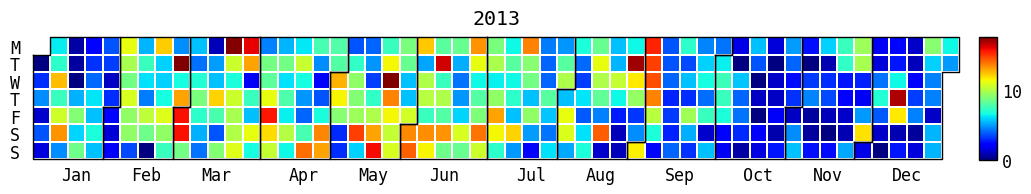

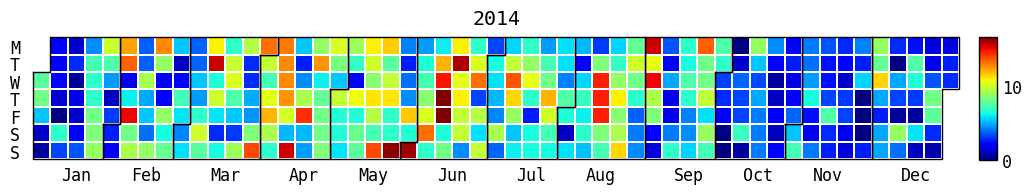

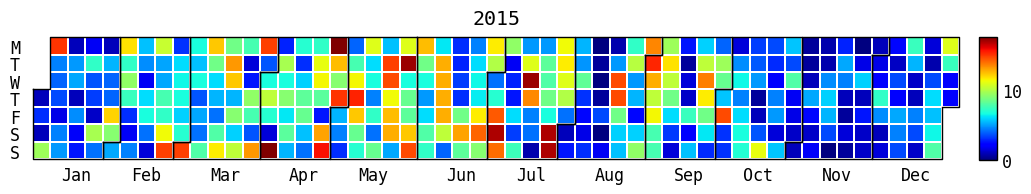

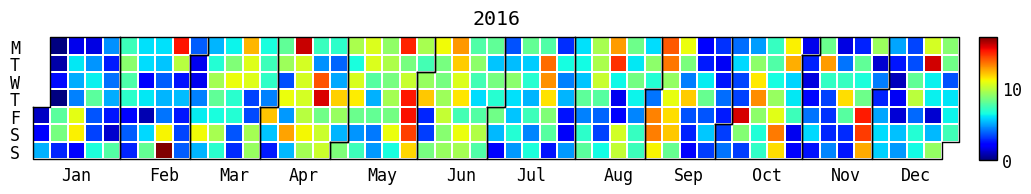

In [66]:
# Calendar plots for each year
july.heatmap(df_2013.index, df_2013['wind_speed'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2014.index, df_2014['wind_speed'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2015.index, df_2015['wind_speed'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2016.index, df_2016['wind_speed'].values, cmap='jet', month_grid=True, colorbar=True)
plt.show()

In [44]:
# Finding Q1 (25% percentile) and Q3 (75% percentile)
Q1_windspeed2 = np.quantile(merged_df['wind_speed'], 0.25)
Q3_windspeed2 = np.quantile(merged_df['wind_speed'], 0.75)

print(f"Q1 for 'wind_speed' variable is: {Q1_windspeed2}")
print(f"Q3 for 'wind_speed' variable is: {Q3_windspeed2}")
print("=================================")

# Finding IQR (Q3-Q1)
IQR_windspeed2 = Q3_windspeed2 - Q1_windspeed2

print(f"IQR for 'wind_speed' variable is: {IQR_windspeed2}")
print("=================================")

# Finding limits (minimum and maximum)
lower_limit_windspeed2 = Q1_windspeed2 - 1.5*IQR_windspeed2
upper_limit_windspeed2 = Q3_windspeed2 + 1.5*IQR_windspeed2

print(f"Lower limit for outlier detection is: {lower_limit_windspeed2}")
print(f"Upper limit for outlier detection is: {upper_limit_windspeed2}")
print("=================================")

# Finding outliers (if a value is < than lower limit or > than upper limit)
outliers_windspeed2 = [x for x in merged_df['wind_speed'] if x < lower_limit_windspeed2 or x > upper_limit_windspeed2]

print(f"{len(outliers_windspeed2)} outliers were found:")
print(outliers_windspeed2)

display(merged_df.loc[merged_df['wind_speed'].isin(outliers_windspeed2)])

Q1 for 'wind_speed' variable is: 3.4875
Q3 for 'wind_speed' variable is: 9.123538461538462
IQR for 'wind_speed' variable is: 5.636038461538463
Lower limit for outlier detection is: -4.966557692307695
Upper limit for outlier detection is: 17.57759615384616
5 outliers were found:
[17.587500000000002, 17.5875, 17.6, 17.5875, 17.59]


,meantemp,humidity,wind_speed,meanpressure,Month,Year
date,,,,,,
2013-02-26,17.857143,70.000000,17.5875,1015.142857,2013-02,2013
2013-05-22,36.750000,22.125000,17.5875,998.625000,2013-05,2013
2015-04-05,23.571429,67.714286,17.6000,1007.750000,2015-04,2015
2015-04-27,30.125000,53.000000,17.5875,1006.750000,2015-04,2015
2017-03-26,29.100000,37.100000,17.5900,1010.200000,2017-03,2017


Even after outlier detection, 5 values were still identified as outliers (*according to the IQR method*).

However, they are not far from the upper limit and thus, will not be corrected with a second analysis.

#### `"meanpressure"`

In the training dataset, the `"meanpressure"` variable is the one showing the **most anomalies**. 

The average standard atmospheric pressure is around `1013.25` millibars, a value that can decrease at most to around `900` millibars as we move up to higher altitudes or in cases of extreme weather events (*typhoons*).

Thus, the maximum and minimum values in our dataset shown above suggest serious anomalies that, in order for proper analysis, need to be changed.

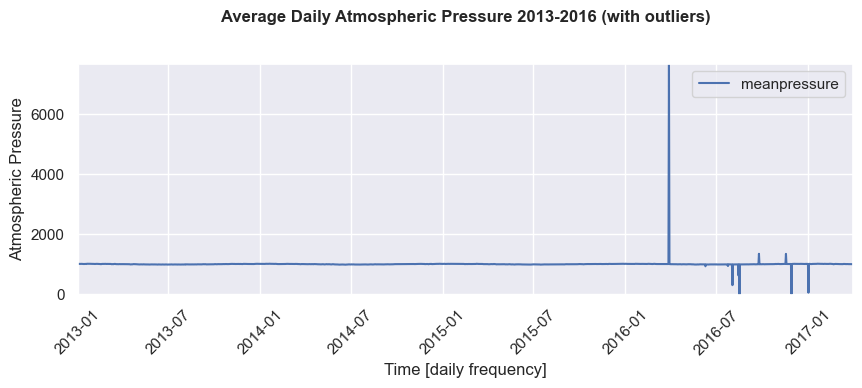

In [53]:
# first "meanpressure" plot
plt.figure(figsize=(10,3))
plt.plot(merged_df['meanpressure'], label='meanpressure')
plt.title('Average Daily Atmospheric Pressure 2013-2016 (with outliers)', weight='bold')
plt.xlabel('Time [daily frequency]')
plt.tick_params(axis='x', rotation=45)
plt.ylabel('Atmospheric Pressure')
plt.legend()
plt.show()

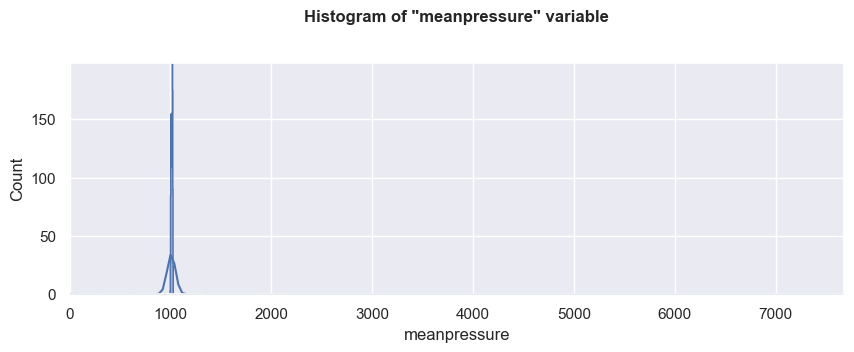

In [54]:
plt.figure(figsize=(10,3))
plt.title('Histogram of "meanpressure" variable', weight='bold')
sns.histplot(data=merged_df, x='meanpressure', kde=True, element='step')
plt.show()

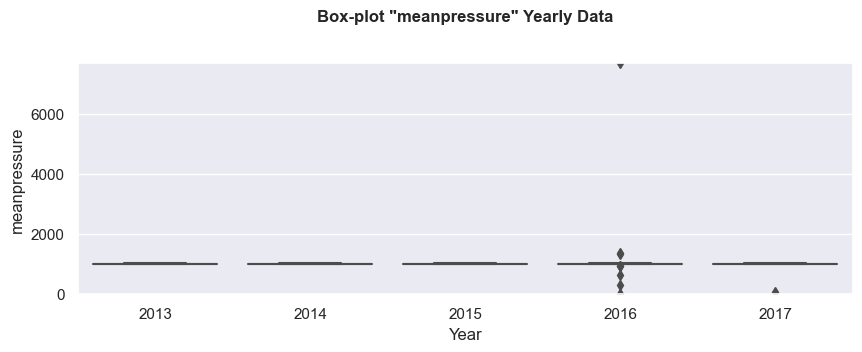

In [55]:
# Box plot "wind_speed"
plt.figure(figsize=(10,3))
sns.boxplot(data=merged_df, x='Year', y='meanpressure').set_title('Box-plot "meanpressure" Yearly Data', weight='bold')
plt.show()

As the graph shows, in the year 2016 there are **huge inconsistencies** in the values that need to be fixed

In [56]:
# Finding Q1 (25% percentile) and Q3 (75% percentile)
Q1_meanpressure = np.quantile(merged_df['meanpressure'], 0.25)
Q3_meanpressure = np.quantile(merged_df['meanpressure'], 0.75)

print(f"Q1 for 'meanpressure' variable is: {Q1_meanpressure}")
print(f"Q3 for 'meanpressure' variable is: {Q3_meanpressure}")
print("=================================")

# Finding IQR (Q3-Q1)
IQR_meanpressure = Q3_meanpressure - Q1_meanpressure

print(f"IQR for 'meanpressure' variable is: {IQR_meanpressure}")
print("=================================")

# Finding limits (minimum and maximum)
lower_limit = Q1_meanpressure - 1.5*IQR_meanpressure
upper_limit = Q3_meanpressure + 1.5*IQR_meanpressure

print(f"Lower limit for outlier detection is: {lower_limit}")
print(f"Upper limit for outlier detection is: {upper_limit}")
print("=================================")

# Finding outliers (if a value is < than lower limit or > than upper limit)
outliers_meanpressure = [x for x in merged_df['meanpressure'] if x < lower_limit or x > upper_limit]

print(f"{len(outliers_meanpressure)} outliers were found:")
print(outliers_meanpressure)


Q1 for 'meanpressure' variable is: 1001.875
Q3 for 'meanpressure' variable is: 1015.2857142857144
IQR for 'meanpressure' variable is: 13.410714285714448
Lower limit for outlier detection is: 981.7589285714283
Upper limit for outlier detection is: 1035.4017857142862
10 outliers were found:
[7679.333333333333, 938.0666666666668, 946.3125, 310.4375, 633.9, -3.0416666666666665, 1352.6153846153843, 1350.2962962962963, 12.045454545454543, 59.0]


In [57]:
# Replacing outliers using 'bfill' method
# First step --> Turn outliers into NaN
merged_df.loc[merged_df['meanpressure'].isin(outliers_meanpressure), 'meanpressure'] = np.nan
# Second step --> Fill NaN
merged_df = merged_df.fillna(method='backfill')

# Update separate dataframes for each year
#2013
df_2013 = merged_df.loc[merged_df.index.year == 2013]
#2014
df_2014 = merged_df.loc[merged_df.index.year == 2014]
#2015
df_2015 = merged_df.loc[merged_df.index.year == 2015]
#2016
df_2016 = merged_df.loc[merged_df.index.year == 2016]

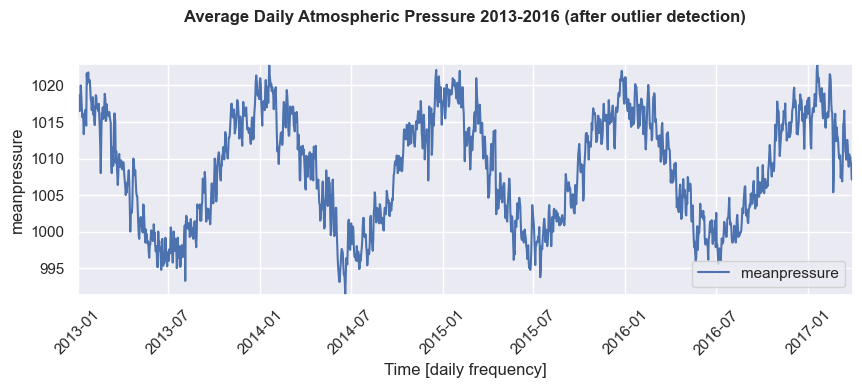

In [58]:
# second "meanpressure" plot (after outlier detection)
plt.figure(figsize=(10,3))
plt.plot(merged_df['meanpressure'], label='meanpressure')
plt.title('Average Daily Atmospheric Pressure 2013-2016 (after outlier detection)', weight='bold')
plt.xlabel('Time [daily frequency]')
plt.tick_params(axis='x', rotation=45)
plt.ylabel('meanpressure')
plt.legend()
plt.show()

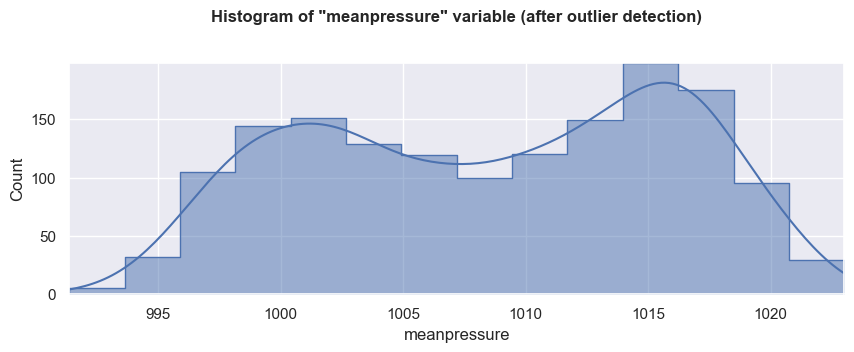

In [59]:
plt.figure(figsize=(10,3))
plt.title('Histogram of "meanpressure" variable (after outlier detection)', weight='bold')
sns.histplot(data=merged_df, x='meanpressure', kde=True, element='step')
plt.show()

In [52]:
display(merged_df['meanpressure'].describe())

count    1551.000000
mean     1008.608525
std         7.437086
min       991.375000
25%      1001.875000
50%      1009.250000
75%      1015.250000
max      1023.000000
Name: meanpressure, dtype: float64

After the outlier detection,`"meanpressure"` variable ranges now from a **minimum** of `991.38` to a **maximum** of `1023`, resulting in an **average** of `1008.61` and a **standard deviation** of `7.44`.

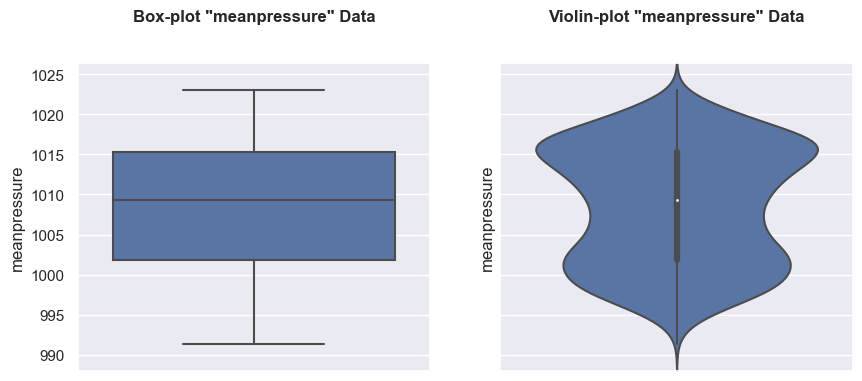

In [60]:
# Box plot / Violin plot - Overall Comparison
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharey=True)
# Box-plot
sns.boxplot(y = merged_df['meanpressure'], ax=ax[0]).set_title('Box-plot "meanpressure" Data', weight='bold')
# Violin-plot
sns.violinplot(y = merged_df['meanpressure'], ax=ax[1]).set_title('Violin-plot "meanpressure" Data', weight='bold')
plt.show()

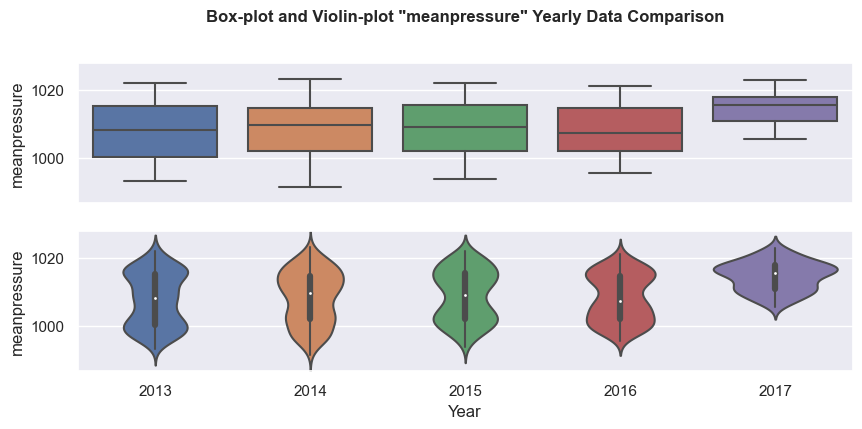

In [61]:
# Box plot / Violin plot - Yearly Comparison
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,4), sharex=True, sharey=True)
# Boxplot
sns.boxplot(data=merged_df, x='Year', y='meanpressure', ax=ax[0]).set_title('Box-plot and Violin-plot "meanpressure" Yearly Data Comparison', weight='bold')
# Violinplot
sns.violinplot(data=merged_df, x='Year', y='meanpressure', ax=ax[1])
ax[0].set_xlabel('')
plt.show()

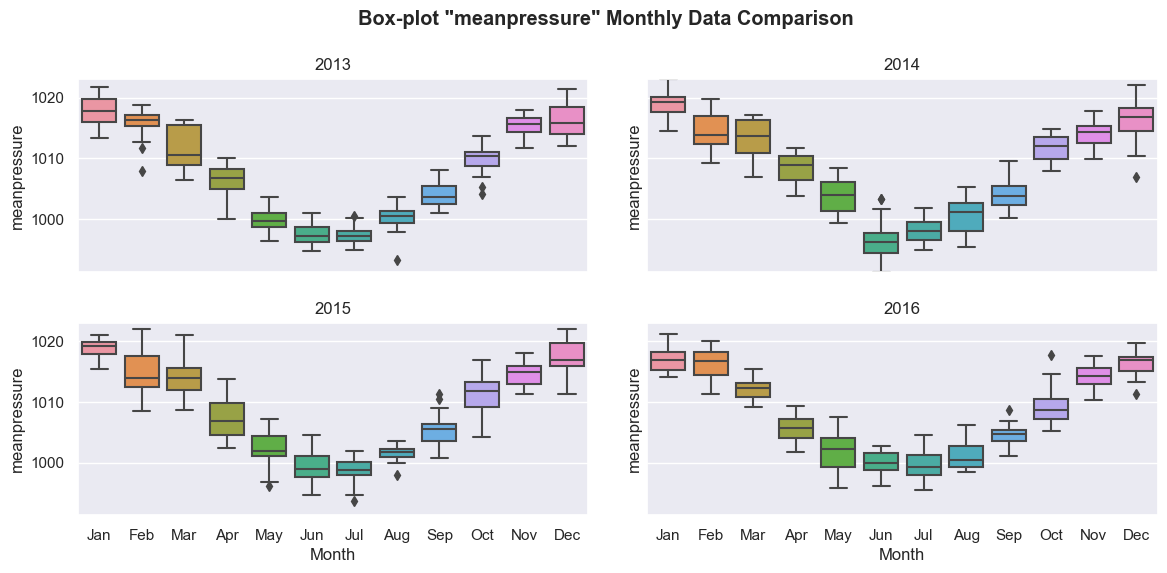

In [62]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,6), sharex=True, sharey=True)
fig.suptitle('Box-plot "meanpressure" Monthly Data Comparison', weight='bold', y=0.95)
fig.tight_layout(pad=2.25)
sns.boxplot(x= df_2013['Month'].dt.strftime('%b'), y= df_2013['meanpressure'], ax=axes[0,0]).set_title('2013', y=0.83)
axes[0,0].set_xlabel('')
sns.boxplot(x= df_2014['Month'].dt.strftime('%b'), y= df_2014['meanpressure'], ax=axes[0,1]).set_title('2014', y=0.83)
axes[0,1].set_xlabel('')
sns.boxplot(x= df_2015['Month'].dt.strftime('%b'), y= df_2015['meanpressure'], ax=axes[1,0]).set_title('2015', y=0.83)
sns.boxplot(x= df_2016['Month'].dt.strftime('%b'), y= df_2016['meanpressure'], ax=axes[1,1]).set_title('2016', y=0.83)
plt.show()

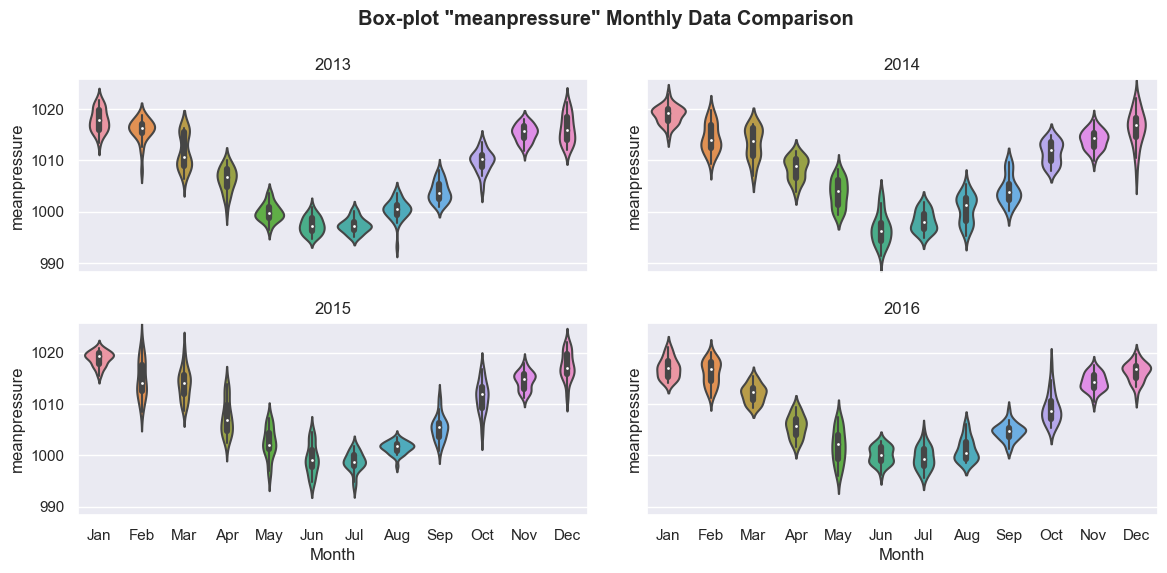

In [63]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,6), sharex=True, sharey=True)
fig.suptitle('Box-plot "meanpressure" Monthly Data Comparison', weight='bold', y=0.95)
fig.tight_layout(pad=2.25)
sns.violinplot(x= df_2013['Month'].dt.strftime('%b'), y= df_2013['meanpressure'], ax=axes[0,0]).set_title('2013', y=0.83)
axes[0,0].set_xlabel('')
sns.violinplot(x= df_2014['Month'].dt.strftime('%b'), y= df_2014['meanpressure'], ax=axes[0,1]).set_title('2014', y=0.83)
axes[0,1].set_xlabel('')
sns.violinplot(x= df_2015['Month'].dt.strftime('%b'), y= df_2015['meanpressure'], ax=axes[1,0]).set_title('2015', y=0.83)
sns.violinplot(x= df_2016['Month'].dt.strftime('%b'), y= df_2016['meanpressure'], ax=axes[1,1]).set_title('2016', y=0.83)
plt.show()

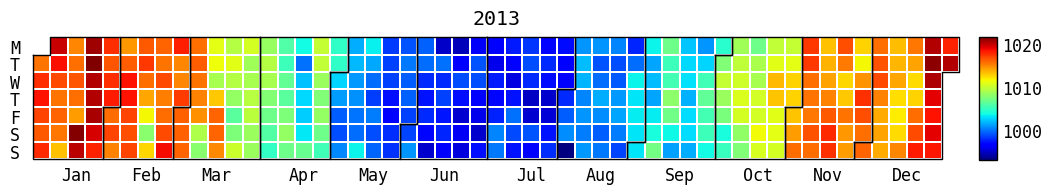

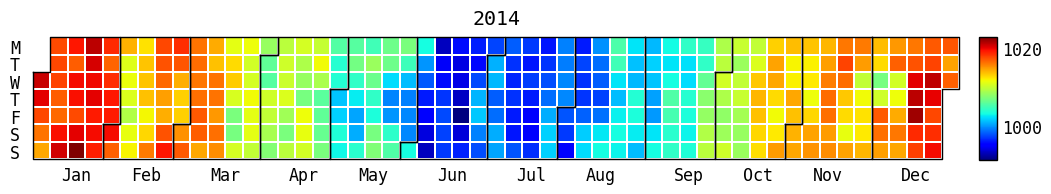

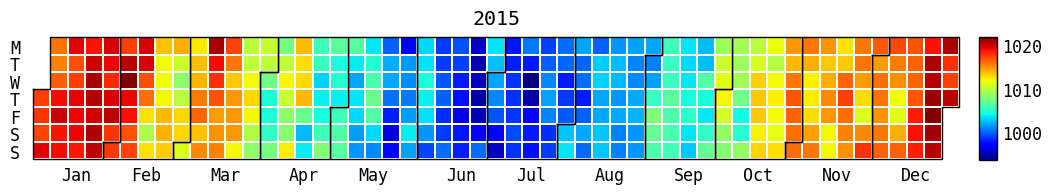

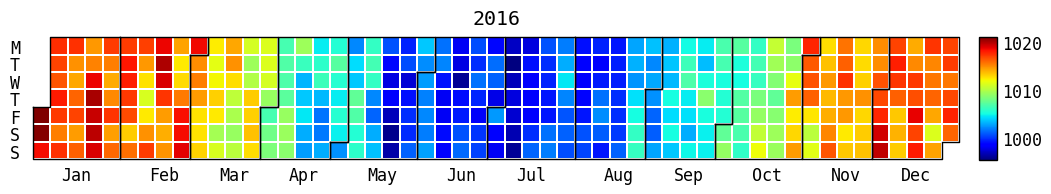

In [64]:
# Calendar plots for each year
july.heatmap(df_2013.index, df_2013['meanpressure'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2014.index, df_2014['meanpressure'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2015.index, df_2015['meanpressure'].values, cmap='jet', month_grid=True, colorbar=True)
july.heatmap(df_2016.index, df_2016['meanpressure'].values, cmap='jet', month_grid=True, colorbar=True)
plt.show()

As can be seen from the graphs, there are **no longer outliers** in the `meanpressure` variable.

### **Correlation**

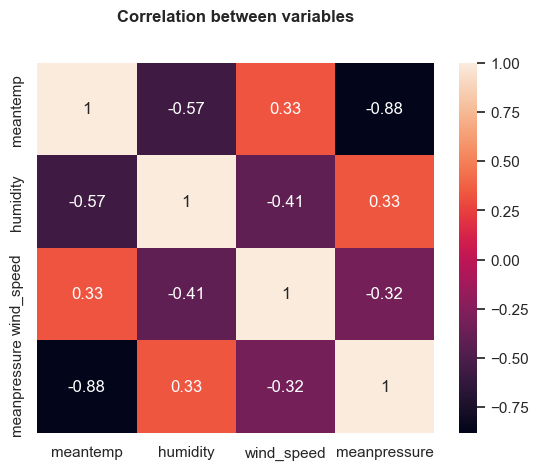

In [64]:
sns.heatmap(merged_df.corr(numeric_only=True), annot=True, cmap='rocket').set_title('Correlation between variables', weight='bold')
plt.show()

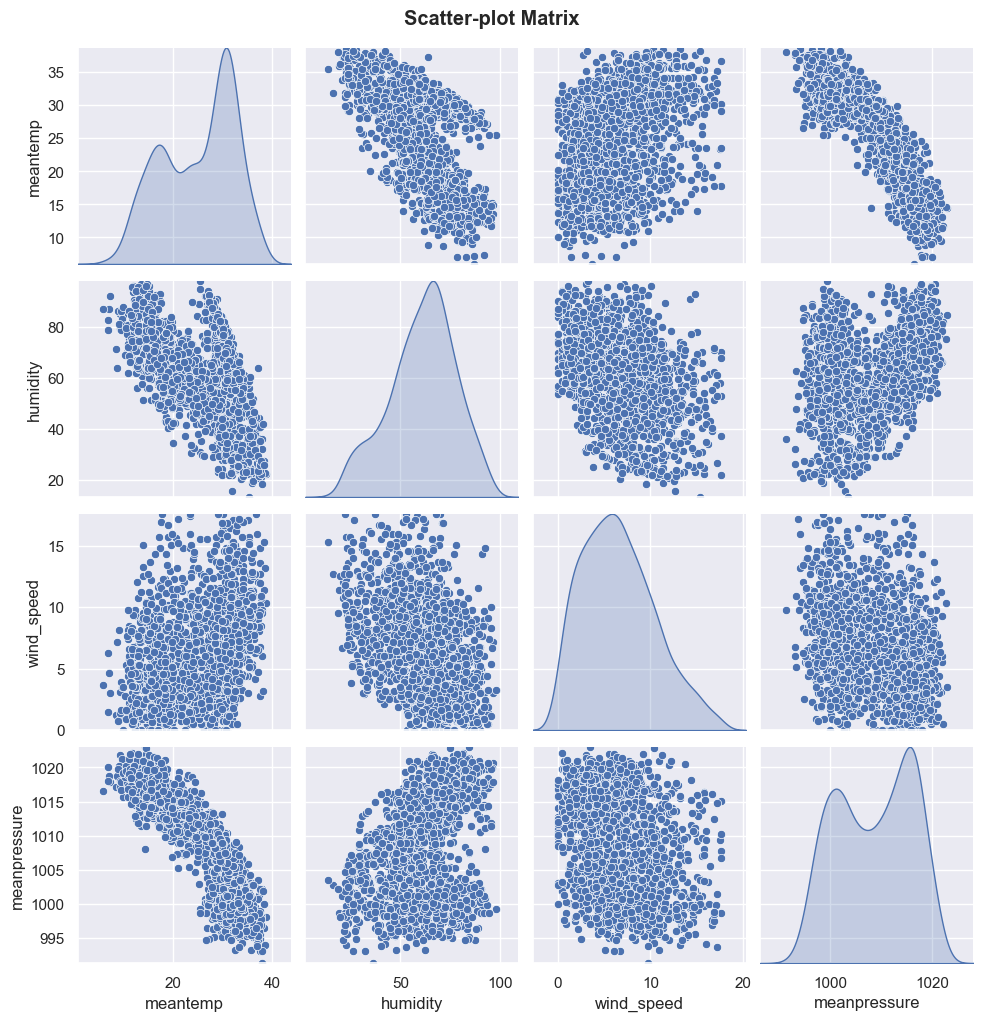

In [65]:
sns.pairplot(data=merged_df, diag_kind='kde').fig.suptitle('Scatter-plot Matrix', weight='bold', y=1.02)
plt.show()

The **heatmap** and **scatter-plot matrix** show the **correlation** between our variables.

There are **no strong positive correlations**:
* **Highest** correlation are between `"humidity"` and `"meanpressure"` and between `"meantemp"` and `"wind_speed"`, having them both a value of `0.33`
* **Lowest** correlation is between `"meantemp"` and `"meanpressure"` with a value of `-0.88` (almost a perfect negative correlation)

The relationship between `"meantemp"` and `"humidity"` is interesting: despite common perception they have a strong negative correlation, with a value of `-0.57`

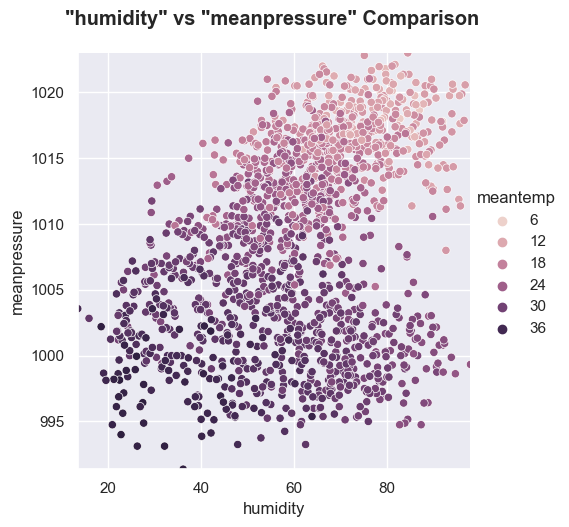

In [66]:
sns.relplot(data=merged_df, x='humidity', y='meanpressure', hue='meantemp').fig.suptitle('"humidity" vs "meanpressure" Comparison', weight='bold', y=1.05)
plt.show()

In [61]:
# Updating training data (2013-2016)
train_data = merged_df[:'2016-12-31']

# Updating testing data (first quarter 2017)
test_data = merged_df['2017-01-01':]

In [62]:
# Converting updated data to new csv
# Merged (train+test)
merged_df.to_csv("cleaned_data/merged_clean.csv")
# Train
train_data.to_csv("cleaned_data/train_clean.csv")
# Test
test_data.to_csv("cleaned_data/test_clean.csv")